In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from scipy.stats import multivariate_normal as mvn
from jax import config


import vsem_jax as vsem
from vsem_inv_prob import (
    InvProb, 
    VSEMPrior, 
    VSEMLikelihood,
    VSEMTest
)

import sys
sys.path.append("./../linear_Gaussian/")
from Gaussian import Gaussian

sys.path.append("./../../samplers/")
from mcmc_uncertainty_prop import gpjaxGP, RandomKernelPCNSampler

rng = np.random.default_rng(6435)
config.update("jax_enable_x64", True)


/opt/miniconda3/envs/modmcmc-dev/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#
# Exact Inverse Problem
#

n_days = 365 * 2
par_names = ["kext", "av"]

# For exact MCMC
proposal_cov = np.diag([0.3**2, 0.04**2])

likelihood = VSEMLikelihood(rng, n_days, par_names)
prior = VSEMPrior(likelihood.par_names, rng)
inv_prob = InvProb(rng, prior, likelihood, proposal_cov=proposal_cov)

In [3]:
#
# Surrogate Inverse Problem
#

vsem_test = VSEMTest(inv_prob, n_design=10)

Optimization terminated successfully.
         Current function value: 49.240726
         Iterations: 60
         Function evaluations: 69
         Gradient evaluations: 69


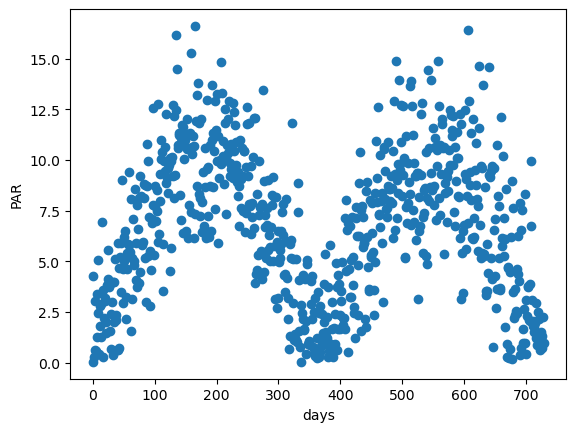

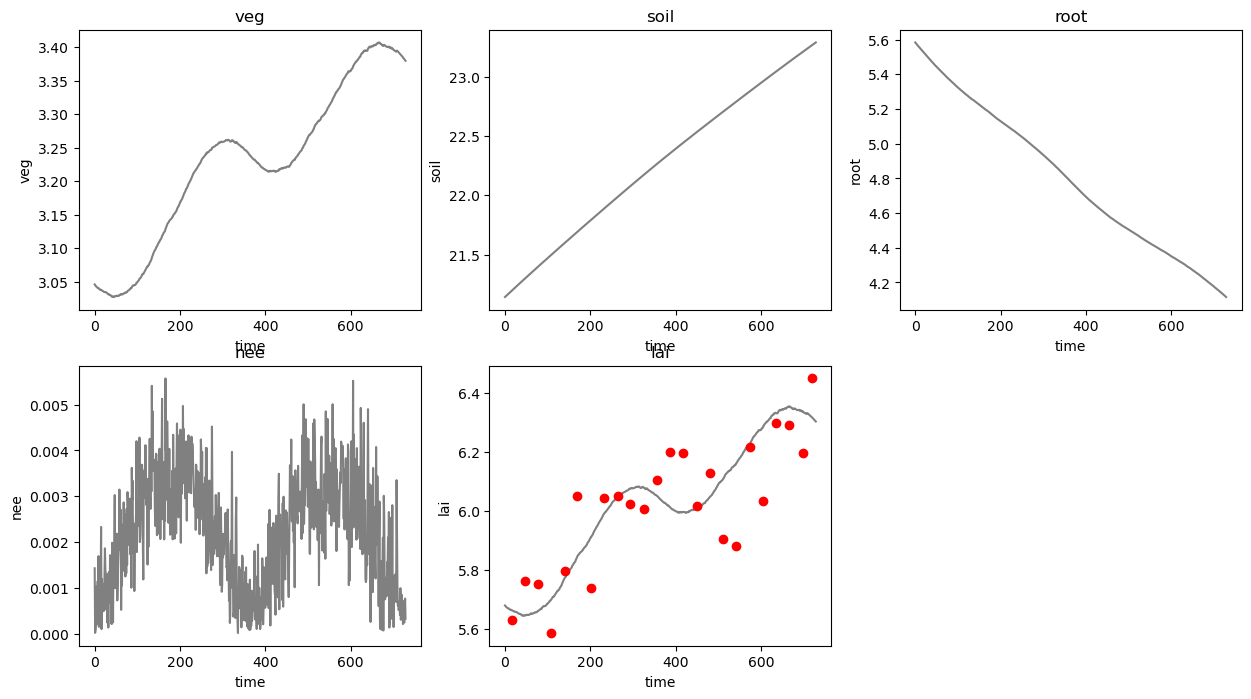

In [4]:
likelihood.plot_driver()
likelihood.plot_ground_truth()

In [ ]:
inv_prob.reset_sampler()
samp, trace_plot = inv_prob.sample_posterior(n_step=10000)

display(trace_plot)

In [ ]:
plt.hist2d(samp[:,0], samp[:,1], bins=30, cmap='Blues')
plt.plot(*likelihood.par_true, "*", color="red", markersize=12)
plt.colorbar(label='Counts per bin')
plt.xlabel('u1')
plt.ylabel('u2')
plt.title('Exact posterior')
plt.show()

In [ ]:
fig_exact, ax_exact = vsem_test.plot_exact_log_post()
fig_gp_post, ax_gp_post = vsem_test.plot_gp_pred(conditional=True, latent_pred=True, figsize=(10,5))
fig_comparison, ax_comparison = vsem_test.plot_true_vs_gp_mean(conditional=True, latent_pred=True, figsize=(10,5))

In [ ]:
fig_comparison.subplots_adjust(bottom=0.3)

display(fig_comparison)

In [ ]:
log_dens_obs = lambda pred_obs: vsem_test.inv_prob.likelihood._likelihood_rv.log_p(pred_obs)
gpwrapped = gpjaxGP(vsem_test.gp_posterior, vsem_test.design, rng)
u_init = vsem_test.inv_prob.prior.sample()

rkpcn = RandomKernelPCNSampler(log_density=log_dens_obs,
                               gp=gpwrapped,
                               u_init=u_init,
                               u_prop_cov=proposal_cov,
                               pcn_cor=0.99,
                               rng=rng)

In [ ]:
test = rkpcn.step()